## **Entrega 1. Control de calidad.**
## **Punto 4. Versión 3 (25/Jul/2024)**
---

- **Docente:** Carlos Arturo Panza Ospino
- **Autores:**
    - Michel Mendivenson Barragán Zabala
    - Juan Sebastián Huertas Piraján
---

**Sea $X ∼ N (\mu_0, \sigma_0)$ una característica de calidad . Se pide:**

- **Mediante simulaciones, establezca el comportamiento del ARL de la Carta $\bar{X}$ con límites tres sigma para observaciones normales.**


---

Anteriormente se había creado una función para muestrear directamente de la distribución $RL$. Sin embargo, uno de los principales problemas de este acercamiento, fue la cantidad pequeña de muestras que se tomaba para calcular el $ARL$ (En ese caso $m = 1000$). Uno de los principales problemas es que la función tardaría alrededor de un minuto para $k = 0$ localmente y en la nube (Collab) alrededor de 40 segundos que al intentar revisar todos los corrimientos (80 aprox) se convierte en un problema de una hora por tamaño de muestra. Así que es necesario cambiar la función para que permita hacer lo mismo, pero muchísimo más rápido:

> - Asignar elementos a un vector dinámicamente X = c() es más costoso.
> - La barra de progreso dentro de la función también puede causar problemas de rendimiento.
> - **Parece ser que el problema más grande en cuanto a rendimiento es que se genera por cada ciclo un subgrupo racional de $n$ elementos proveniente de una normal**.
> - La función `rnorm` de R genera muestras independientes entre sí.

Teniendo todo esto en cuenta, es posible generar un código más rápido así:


In [1]:
RunLengthX_Optimized = function(mu = 0, sigma = 1, L = 3, Corrimiento = 0, n = 3, m = 1000){


    # Barra de progreso
    pb = txtProgressBar(min = 0, max = m, style = 3)
    # Límites de control
    UCL = mu + L * sigma/sqrt(n)
    LCL = mu - L * sigma/sqrt(n)

    medias = c()
    RL = c()

    # Corrimiento
    mu1 = mu + Corrimiento * sigma
    while (length(RL) < m){
        medias = c(medias,
                   colMeans(matrix(rnorm(n*m*100, mean = mu1, sigma), 
                          nrow = n, byrow = F)))
        OutControl = which(medias < LCL | medias > UCL)
        RL = diff(c(0, OutControl))
        setTxtProgressBar(pb, length(RL))
    }
    setTxtProgressBar(pb, m)
    return(RL[1:m])
}

# DISCLAIMER: La idea de generar lotes de muestras fue concebida por una IA lástimosamente, aunque al principio no servía so... el arreglo sí fue mío xd
# ACLARACIÓN: La función está probada con la directa (La que se tenía antes) pues con la misma semilla demostraron dar el mismo resultado

Este código resulta ser muchísimo más rápido lo que nos permite estimar el $ARL$ con una cantidad de muestras mayor:

In [2]:
set.seed(10)
system.time(RunLengthX_Optimized(m = 10000))

  |======================================================================| 100%

   user  system elapsed 
  1.204   0.124   1.362 

En comparación a la función que se tenía antes:

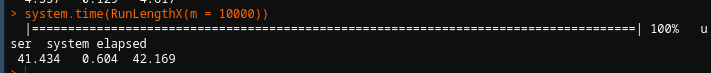

Ahora sí, podemos proceder con la estimación del $ARL$ como ya habíamos procedido antes:

In [3]:
library(parallel)
library(pbmcapply)
cores = detectCores()

In [4]:
corrimientos = seq(0,3, by = 0.025)
m = 50000
resultados = matrix(ncol = length(corrimientos), nrow = 3, 
                    dimnames = list(c('Teórico', 'Fase I (20 subgrupos)', 'Fase I (50 subgrupos)'),
                                   corrimientos))
resultados['Teórico',] = as.numeric(pbmclapply(corrimientos, FUN = function(x) mean(RunLengthX_Optimized(Corrimiento = x, m = m, n = 3)),
                                                         mc.cores = cores, mc.set.seed = 1305))

# NOTA: Otro error que se tenía anteriormente es que como los subgrupos racionales de la fase I eran
#       de tamaño n = 3 no se pude usar otro tamaño en fase II

In [5]:
resultados[, as.character(seq(0,3, by = 0.2))]

,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3
Teórico,370.7008,227.129,94.6484,40.02746,18.7347,9.72192,5.64532,3.5349,2.43508,1.83854,1.47734,1.26286,1.13642,1.0708,1.03262,1.01402
Fase I (20 subgrupos),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Fase I (50 subgrupos),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
**Sea $X ∼ N (\mu_0, \sigma_0)$ una característica de calidad . Se pide:**

- **Genere 20 subgrupos racionales de tamaño $n = 3$ provenientes de $X$. Asumáse que el proceso es estable en cuanto a dispersión y con lo subgrupos iniciales, construya la carta $\bar{X}$ como es habitual hasta verificar la estabilidad del proceso. establezca el comportamiento del ARL para la carta que se obtienen del análisis de Fase I realizado.**

---

Nuevamente, una de las cosas importantes en este punto es poder generar muestras lo suficientemente grandes para generar estimaciones del ARL más precisas. Por ende, modificaremos ligeramente la función de generación de muestras además la corrección importante se mencionará cuando se inicie el análisis en fase II pues primeramente se debe hacer el análisis en fase I:

In [6]:
# Generación de subgrupos racionales
mu = 0; sigma = 1                 # Parámetros para muestra aleatoria
n = 3; m = 20                     # Tamaño de muestra y cantidad de muestras              
set.seed(10)                      # Semilla para replicación
muestras = matrix(nrow = m, ncol = n)
for (i in 1:m){
  muestras[i,] = rnorm(n, mean = mu, sd = sigma)
}

In [7]:
# En este punto, preparamos la carta: Estimamos los parámetros necesarios 
# y calculamos los límites de la carta
medias = rowMeans(muestras)               # Media de cada una de las muestras
rangos = apply(muestras, MARGIN = 1,      # Rango de cada una de las muestras
               FUN = function(x) diff(range(x)))
rango = mean(rangos)                      # Media de los rangos
media = mean(medias)                      # Media de las medias

d2 = 1.693                                # Constante para hacer insesgado al rango.

UCL = media + (3 / sqrt(n)) * (rango / d2)
LCL = media - (3 / sqrt(n)) * (rango / d2)

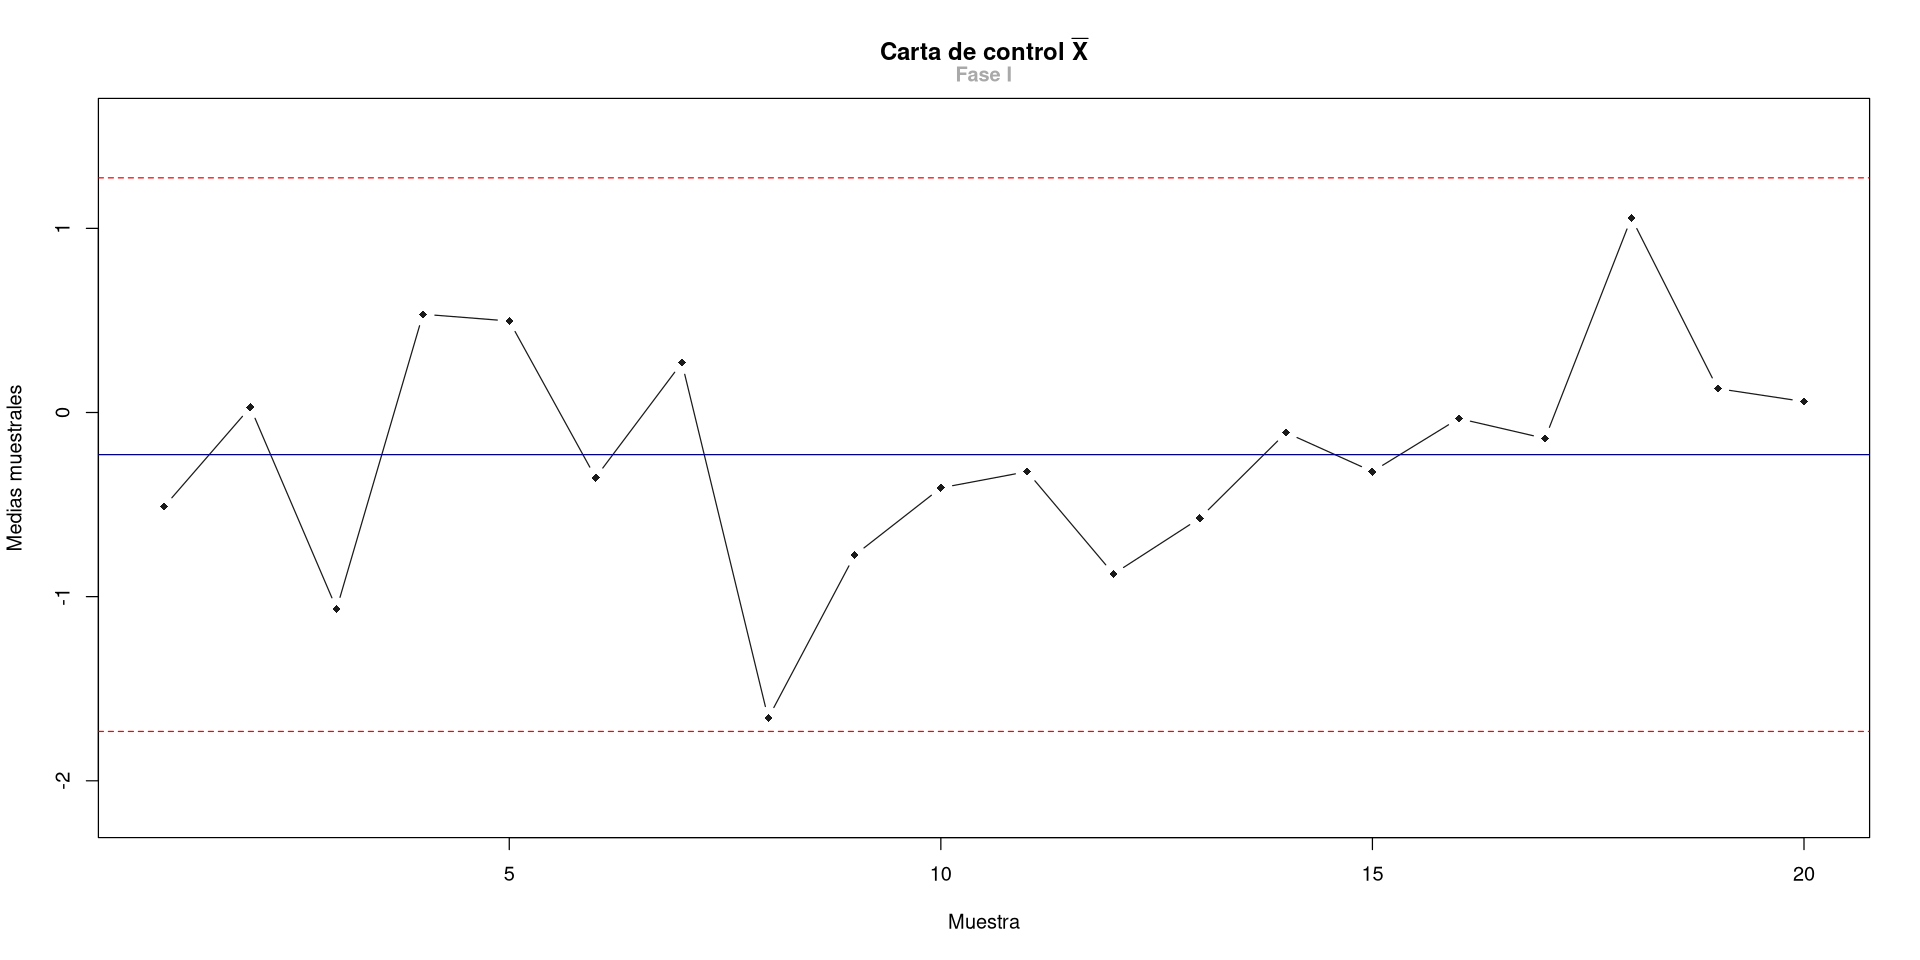

In [8]:
# Cambiando las dimensiones del gráfico
options(repr.plot.width = 16, repr.plot.height = 8)

# Ahora graficamos la carta para revisar qué puntos caen fuera de la zona de control
# Gráfica
plot(medias, type = 'b', pch = 18, cex = 0.9, col = 'gray10',  xlab = 'Muestra',
     ylim = c(min(min(medias) - 0.5,LCL),max(max(medias) + 0.5,UCL)),
     ylab = 'Medias muestrales', main = latex2exp::TeX('\\textbf{Carta de control $\\bar{X}$}'))

mtext(bquote(bold('Fase I')), side = 3, line = 0.5, adj = 0.5, col = 'darkgray')
abline(h = c(LCL,UCL, media), col = c('red', 'red', 'darkblue'), 
       lty = c('dashed', 'dashed', 'solid'))

# En caso de haber puntos fuera de la zona de control se pintan de naranja
indicesOut = which(medias < LCL | medias > UCL) # Los puntos que están fuera de control
points(x = indicesOut, y = medias[indicesOut], col = 'orange', pch = 19, cex = 0.8)

Como no hay puntos fuera de la zona de control, podemos proceder con el análisis en fase II sin necesidad de eliminar ningún punto de la muestra inicial de realizaciones de $\bar{\bar{X}}$. Por otro lado, respecto a la corrección:

> Hay que agregar $A_2$ al cálculo de los límites de control. La respuesta es de nuevo, ya lo habíamos agregado, pero por error del grupo no se mostró en el desarrollo de la clase y se dejó $L$ como argumento de elección (Aunque aún tengo mis dudas de si ese L se puede modificar). Eso sí, hay que recordar que $A_2 = \frac{3}{d_2 \times \sqrt{n}}$ y por ende $A_2 \times \bar{R} = \frac{3}{\sqrt{n}} \times \frac{\bar{R}}{d_2}$
>
> Además, también es importante notar que sí había un error importante: Se estaba usando una carta construida en fase I para construir cartas de control de otros tamaños. +++

In [13]:
cat('Las estimaciones para el proceso estable son: \n',
    '\t * Media = ', media,'\n',
    '\t * Rango = ', rango, end = '\n')

# Sin embargo, el rango es una estimación sesgada que debe ser corregida por d2 por lo que:
sigma = rango/d2
cat('\t * Sigma = ', sigma)

Las estimaciones para el proceso estable son: 
 	 * Media =  -0.2287718 
 	 * Rango =  1.469292 
	 * Sigma =  0.8678629

Teniendo eso en cuenta, la función que utilizaremos para este fin es:

In [37]:
RunLengthXMod_Optimized = function(mu1 = 0, sigma1 = 1,               # Parámetros estimados del proceso
                                   mu = 0, sigma = 1,                 # Parámetros reales del proceso
                                   L = 3, Corrimiento = 0,
                                   n = 3, m = 1000){
  pb = txtProgressBar(min = 0, max = m, style = 3)
  
  # Límites de control
  UCL = mu1 + L * sigma1/sqrt(n)             # Tenga en cuenta que sigma1 = Rango/d2 por lo que 
  LCL = mu1 - L * sigma1/sqrt(n)             # L/sqrt(n) * sigma1 = A_2 * R. Además, si quisieramos usar
  # otro tamaño de muestra necesitaríamos cambiar a d2.
  
  medias = c()                               # Medias de los subgrupos racionales
  RL = c()                                   # Muestras de longitud de corrida
  last_count = 0                             # Place holder ¿Cuántas muestras quedaron al final de las medias sin salirse de la zona de control? 
  # Corrimiento
  muCorr = mu + Corrimiento * sigma          # Media del proceso con corrimientos
  
  
  while (length(RL) < m){
    # Se calculan n*m*100 medias y se revisa qué medias quedaron fuera de control
    medias = colMeans(matrix(rnorm(n*m*100, mean = muCorr, sigma), 
                             nrow = n, byrow = F))
    
    # Se consiguen los índices de las medias que quedaron fuera de control (i.e Tiempo)
    OutControl = which(medias < LCL | medias > UCL)
    
    # Se calcula el tiempo real (Como reiniciar el proceso después de una señal)
    OutControl = diff(c(0, OutControl))
    
    # Al final del vector vana quedar z cantidad de muestras que no dieron señal
    # y eso es o que lleva la variable de last_count
    OutControl[1] = OutControl[1] + last_count
    last_count =  length(medias) - OutControl[length(OutControl)]
    
    RL = c(RL, OutControl)
    setTxtProgressBar(pb , length(RL))
  }
  setTxtProgressBar(pb, m)
  return(RL[1:m])
}

# NOTA: La función anterior era muy rápida, pero ocupaba demasiada memoria y es posible quedarse sin memoria, 
#       en teoría esta función debería ocupar menos memoria.

Ya teniendo la función, lo que hacemos es generar las estimaciones del ARL para distintos tamaños de muestra. Y como generamos el ARL para distintos tamaños de muestra tenemos que estar modificando el valor de $d_2$ y por ende la estimación de $\sigma_1$:

In [15]:
library(parallel)
library(pbmcapply)
cores = detectCores()

In [16]:
corrimientos = seq(0,3, by = 0.025)
m = 50000
resultados['Fase I (20 subgrupos)',] = as.numeric(pbmclapply(corrimientos, FUN = function(x) mean(RunLengthXMod_Optimized(mu1 = media, sigma1 = sigma ,Corrimiento = x, m = m, n = 3)),
                                                       mc.cores = cores, mc.set.seed = 1305))

In [17]:
resultados[, as.character(seq(0,3, by = 0.2))]

,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3
Teórico,370.7008,227.12904,94.64840,40.02746,18.73470,9.72192,5.64532,3.53490,2.43508,1.83854,1.47734,1.26286,1.13642,1.07080,1.03262,1.01402
Fase I (20 subgrupos),66.7413,31.40162,15.32916,8.20968,4.87108,3.13632,2.22686,1.71702,1.39926,1.21796,1.11974,1.05756,1.02616,1.01066,1.00442,1.00170
Fase I (50 subgrupos),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---

**Sea $X ∼ N (\mu_0, \sigma_0)$ una característica de calidad . Se pide:**

- **Repetir lo indicado en el literal anterior con 50 subgrupos racionales de tamaño n = 3. Comente los resultados.**

---

Teniendo en cuenta todo lo dicho anteriormente y que ya tenemos una función desarrollada no debería ser complicado desarrollar este punto:

- Generamos la muestra de subgrupos racionales

In [20]:
# Generamos la muestra de 50 subgrupos racionales de tamaño 3
mu = 0; sigma = 1                 # Parámetros para muestra aleatoria
n = 3; m = 50                     # Tamaño de muestra y cantidad de muestras              
set.seed(1305)                     # Semilla para replicación
muestras = matrix(nrow = m, ncol = n)
for (i in 1:m){
  muestras[i,] = rnorm(n, mean = mu, sd = sigma)
}

- Verificamos que ningun punto de la media caiga fuera de la zona de control (Fase I)

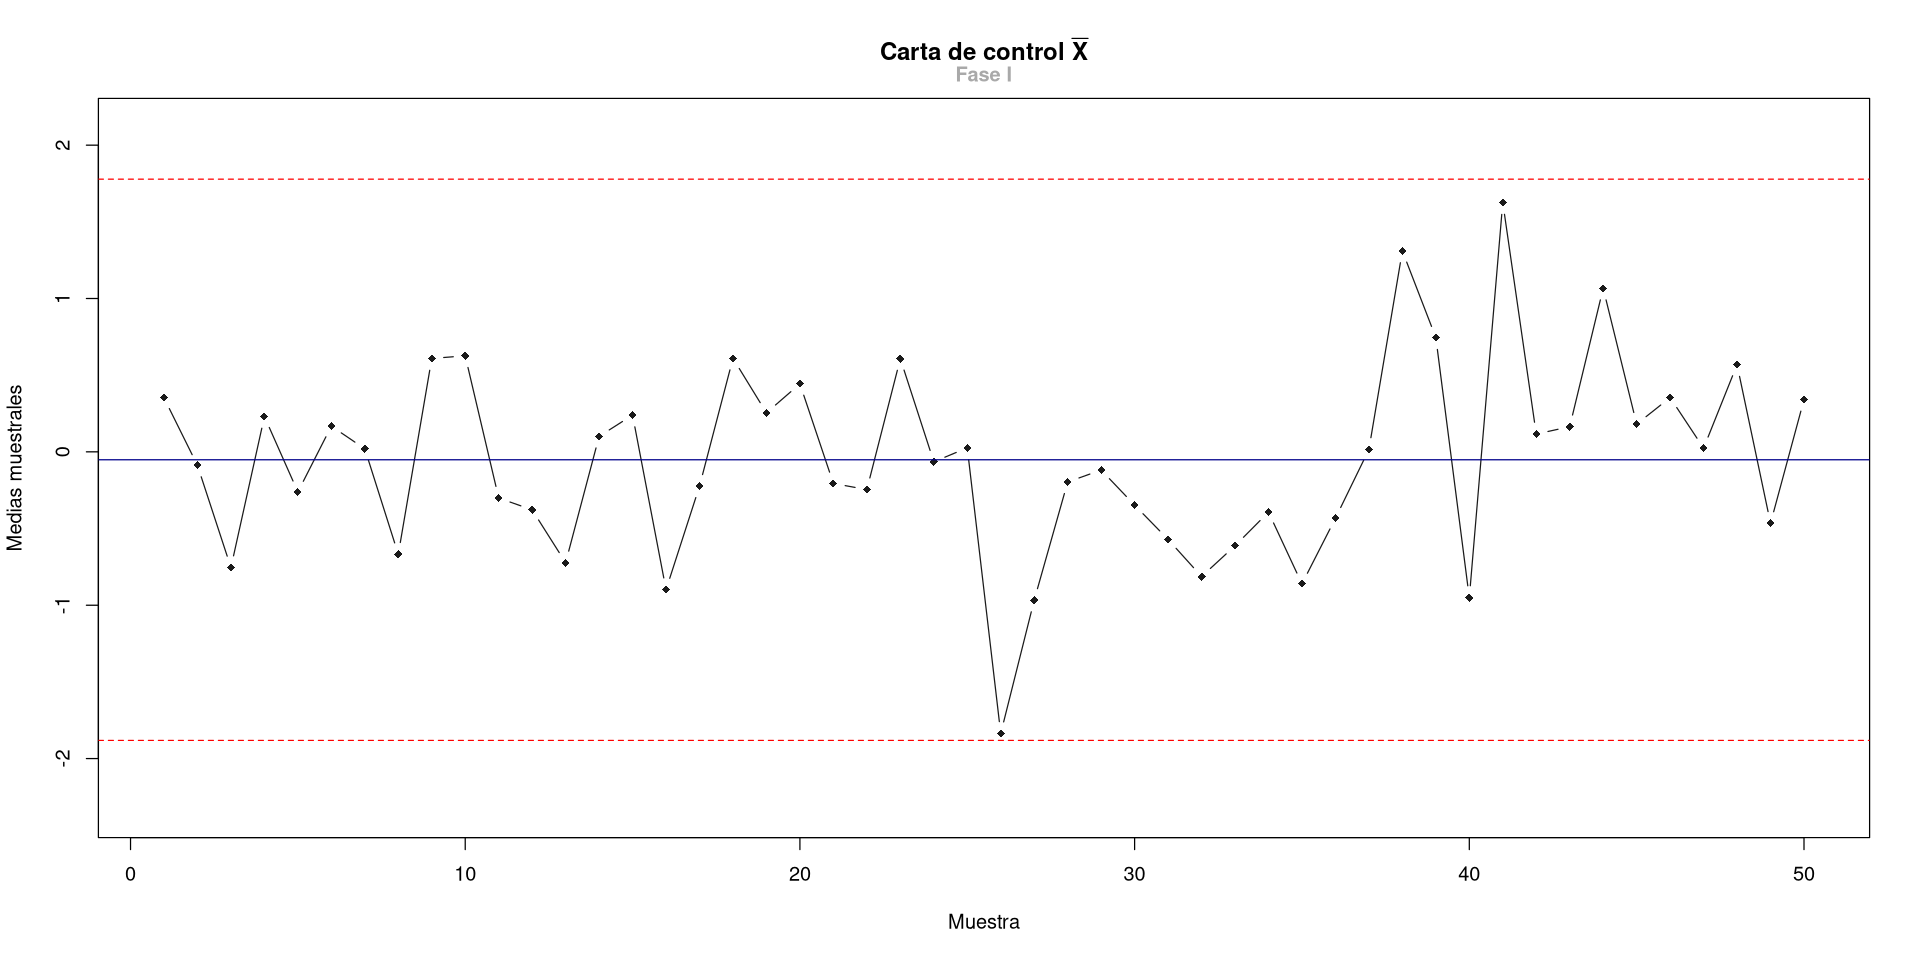

In [21]:
# Cambiando las dimensiones del gráfico
options(repr.plot.width = 16, repr.plot.height = 8)

# ==> ANÁLISIS DE FASE I:

medias = rowMeans(muestras)               # Media de cada una de las muestras
rangos = apply(muestras, MARGIN = 1,      # Rango de cada una de las muestras
               FUN = function(x) diff(range(x)))
rango = mean(rangos)                      # Media de los rangos
media = mean(medias)                      # Media de las medias

d2 = 1.693                                # Constante para hacer insesgado al rango.

UCL = media + (3 / sqrt(n)) * (rango / d2)
LCL = media - (3 / sqrt(n)) * (rango / d2)

# Gráfica
plot(medias, type = 'b', pch = 18, cex = 0.9, col = 'gray10',  xlab = 'Muestra',
     ylim = c(min(min(medias) - 0.5,LCL),max(max(medias) + 0.5,UCL)),
     ylab = 'Medias muestrales', main = latex2exp::TeX('\\textbf{Carta de control $\\bar{X}$}'))

mtext(bquote(bold('Fase I')), side = 3, line = 0.5, adj = 0.5, col = 'darkgray')
abline(h = c(LCL,UCL, media), col = c('red', 'red', 'darkblue'), 
       lty = c('dashed', 'dashed', 'solid'))

indicesOut = which(medias < LCL | medias > UCL) # Los puntos que están fuera de control
points(x = indicesOut, y = medias[indicesOut], col = 'orange', pch = 19, cex = 0.8)


In [22]:
# Observe que la gráfica no contiene puntos por fuera de los límites de control por lo que:
sigma = rango/d2
cat('Las estimaciones para el proceso estable son: \n',
    '\t * Media = ', media,'\n',
    '\t * Rango = ', rango,'\n',
    '\t * Sigma = ', sigma)

Las estimaciones para el proceso estable son: 
 	 * Media =  -0.05161904 
 	 * Rango =  1.788639 
 	 * Sigma =  1.056491

Nuevamente, como ninguna muestra cae por fuera de la zona de control podemos proceder conforme lo hicimos anteriormente al análisis de fase II:

In [23]:
library(parallel)
library(pbmcapply)
cores = detectCores()

In [38]:
corrimientos = seq(0,3, by = 0.025)
m = 50000
resultados['Fase I (50 subgrupos)',] = as.numeric(pbmclapply(corrimientos, FUN = function(x) mean(RunLengthXMod_Optimized(mu1 = media, sigma1 = sigma ,Corrimiento = x, m = m, n = 3)),
                                                       mc.cores = cores, mc.set.seed = 1305))

In [39]:
resultados[, as.character(seq(0,3, by = 0.2))]

,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3
Teórico,370.7008,227.12904,94.64840,40.02746,18.73470,9.72192,5.64532,3.53490,2.43508,1.83854,1.47734,1.26286,1.13642,1.07080,1.03262,1.01402
Fase I (20 subgrupos),66.7413,31.40162,15.32916,8.20968,4.87108,3.13632,2.22686,1.71702,1.39926,1.21796,1.11974,1.05756,1.02616,1.01066,1.00442,1.00170
Fase I (50 subgrupos),1228.2080,606.05690,216.95840,49.13202,22.08038,11.24662,6.31776,3.91930,2.62886,1.93340,1.53862,1.30208,1.16140,1.08122,1.04010,1.01730


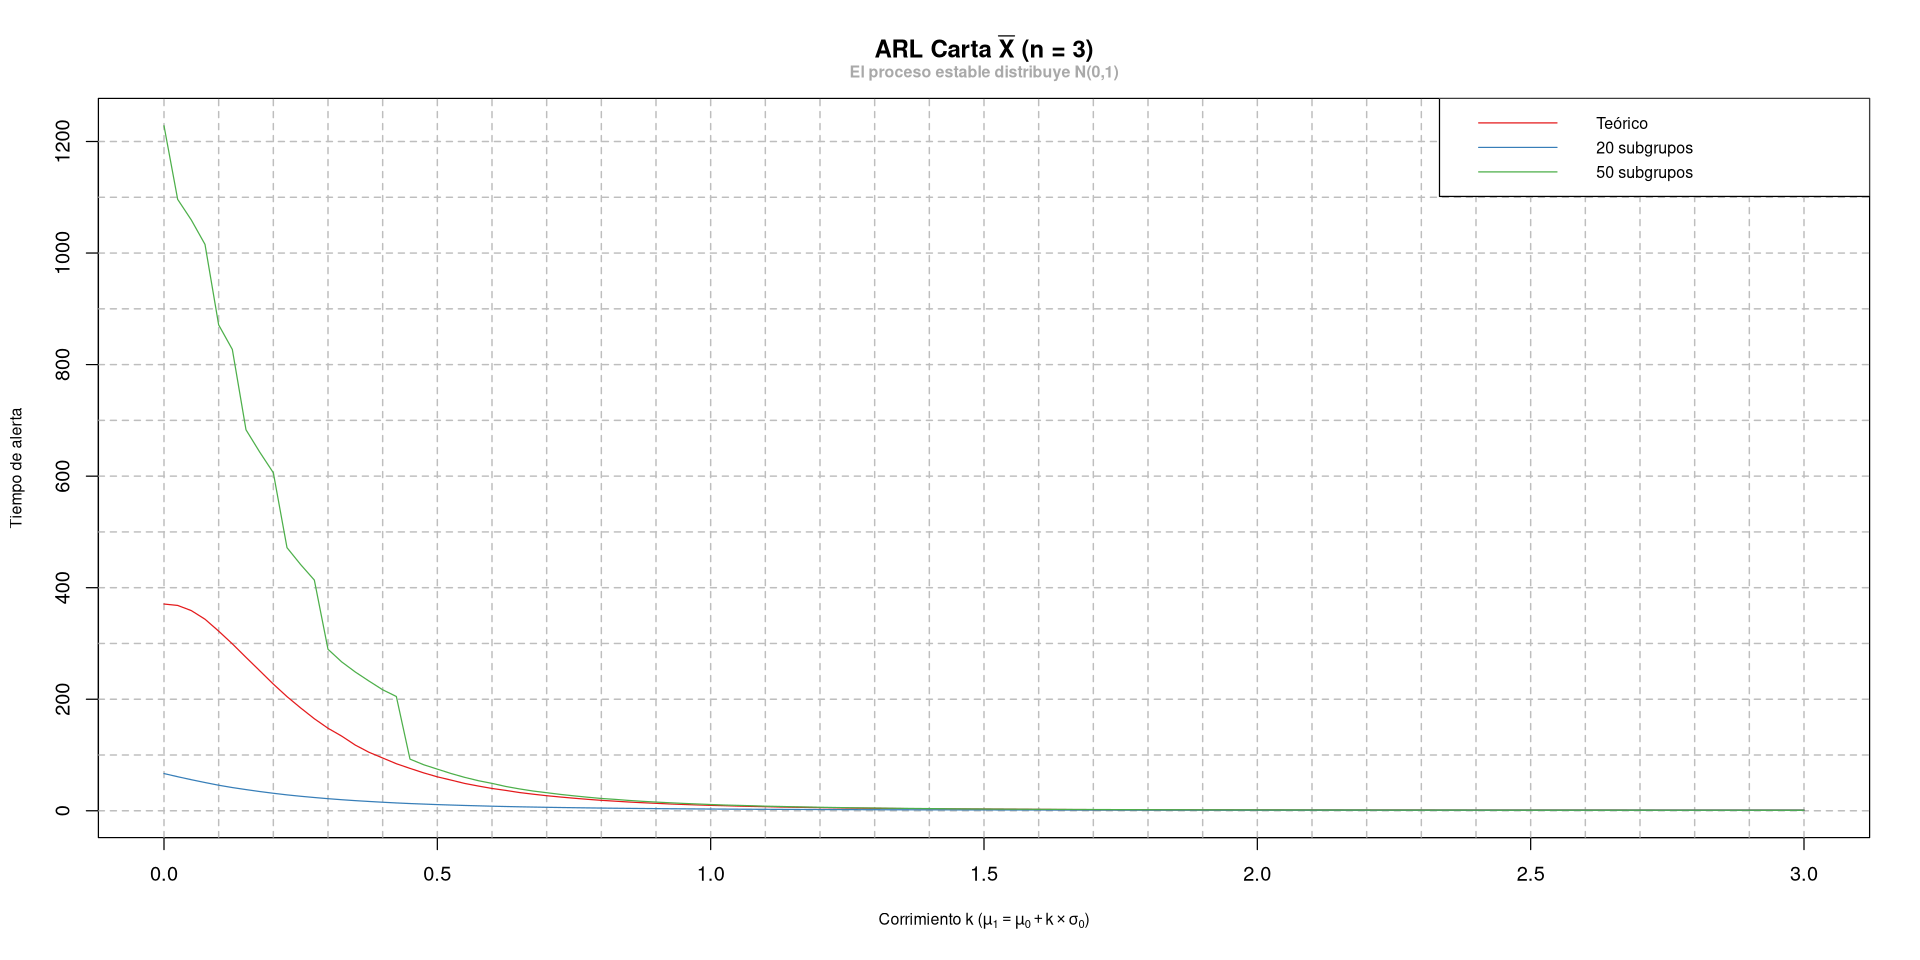

In [36]:
options(repr.plot.width = 16, repr.plot.height = 8)

# Generando un gráfico vacío
colores  = RColorBrewer::brewer.pal(4, name = 'Set1')     # Elección de colores
plot(x = NULL, y = NULL, ylim = range(resultados),        # Gráfico vacío
     xlim = range(as.numeric(colnames(resultados))),cex.lab = 0.8,
     main = latex2exp::TeX('\\textbf{ARL Carta $\\bar{X}$ (n = 3)}'), ylab = 'Tiempo de alerta',
     xlab = latex2exp::TeX('Corrimiento $k$ ($\\mu_1 = mu_0 + k \\times \\sigma_0$)'))
mtext(bquote(bold('El proceso estable distribuye N(0,1)')), side = 3, line = 0.5,
      adj = 0.5, cex = 0.8, col = 'darkgray')

# Cuadrícula
abline(v = seq(0, 3, by = 0.1), col = 'gray', lwd = 1.2, lty = 'dashed')
abline(h = seq(0, 1200, by = 100), col = 'gray', lwd = 1.2, lty = 'dashed')

# Leyenda
legend('topright',legend = c('Teórico', '20 subgrupos', '50 subgrupos'), col = colores, 
       lty = 'solid',bty = 'solid', cex = 0.8, bg = 'white')

# Graficando ya como tal
for (i in 1:3){
  lines(x = as.numeric(colnames(resultados)),y = resultados[i,], col = colores[i])
}

### **Comentarios finales**

No entiendo nada XD ¿Deberían dar tan distinto? :0 Teniendo en cuenta que los límites para la última carta son:

In [47]:
media - 3/sqrt(n) * sigma

[1] -1.881515